In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🚀 OIL SPILL DETECTION SYSTEM - FIXED VERSION
📤 UPLOAD SATELLITE IMAGES
Fixed version - handles 100% coverage cases
------------------------------------------------------------


Saving Oil (1014).jpg to Oil (1014) (2).jpg

✅ Uploaded 1 file(s)

🔍 ANALYZING: Oil (1014) (2).jpg
🔄 Loading trained models...


✅ Classification model loaded
✅ Segmentation model loaded
   Input shape: (None, 256, 256, 3)
📐 Original size: 1920x1080
🎨 Image mode: RGB
🔍 Running actual segmentation model...
   Classification output: 0.9905
   Raw prediction shape: (1, 256, 256, 1)
   Prediction range: [0.357, 0.525]
   Actual detection: 257 pixels (0.39%)
📊 FINAL DETECTION RESULTS:
   - Oil spill detected: True
   - Confidence: 99.0%
   - Oil pixels: 257
   - Oil coverage: 0.3922%

🌊 OIL SPILL DETECTION RESULTS
🚨 OIL SPILL DETECTED
📊 Model Confidence: 99.0%
⚠️  Risk Level: ⚪ VERY LOW
🛢️  Oil Coverage: 0.39%
📈 Detected Area: 257 pixels


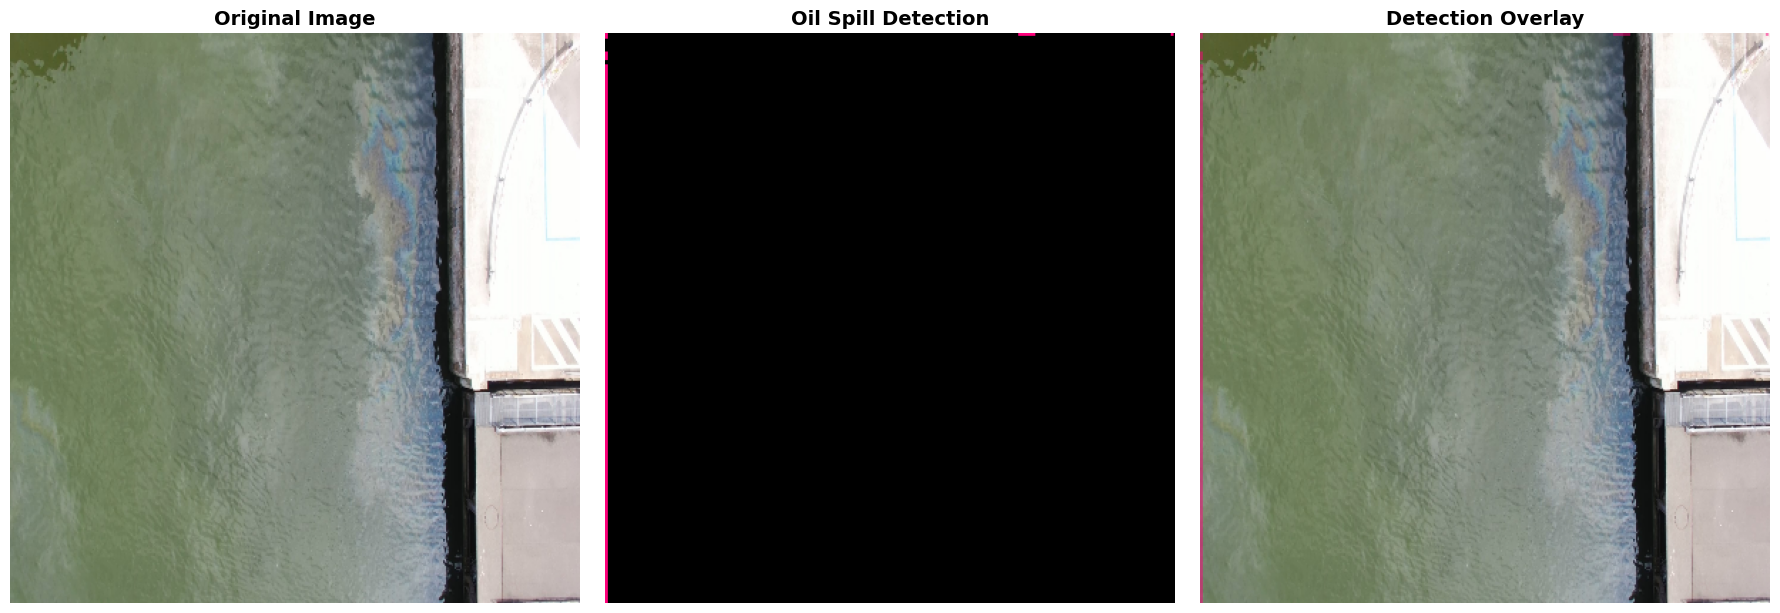


🔧 TECHNICAL DETAILS:
-------------------------
Model: U-Net Segmentation
Threshold: 0.5
Image size: 256x256
Oil pixels: 257

💡 ANALYSIS:
---------------
✅ Minimal or no oil detected
   Area appears clean
✅ Analysis completed successfully!


🎯 ALL ANALYSES COMPLETED!


In [36]:
# OIL SPILL DETECTION - FIXED VERSION
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
import os

print("🚀 OIL SPILL DETECTION SYSTEM - FIXED VERSION")
print("="*60)

class OilSpillDetector:
    def __init__(self):
        self.classification_model = None
        self.segmentation_model = None
        self.load_trained_models()

    def load_trained_models(self):
        """Load actual trained models"""
        print("🔄 Loading trained models...")

        # Load classification model
        cls_model_path = '/content/drive/MyDrive/models/simple_cnn_classifier.h5'
        if os.path.exists(cls_model_path):
            try:
                self.classification_model = tf.keras.models.load_model(cls_model_path)
                print("✅ Classification model loaded")
            except Exception as e:
                print(f"❌ Classification model error: {e}")

        # Load segmentation model
        seg_model_path = '/content/drive/MyDrive/models/best_unet_model.h5'
        if os.path.exists(seg_model_path):
            try:
                self.segmentation_model = tf.keras.models.load_model(seg_model_path, compile=False)
                print("✅ Segmentation model loaded")
                print(f"   Input shape: {self.segmentation_model.input_shape}")
            except Exception as e:
                print(f"❌ Segmentation model error: {e}")

    def preprocess_image(self, image):
        """Preprocess image for model input"""
        if isinstance(image, Image.Image):
            image = np.array(image)

        # Convert to RGB if needed
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        elif image.shape[-1] == 4:
            image = image[..., :3]

        # Resize to 256x256 (model input size)
        image_resized = cv2.resize(image, (256, 256))

        # Normalize to [0, 1]
        image_normalized = image_resized.astype(np.float32) / 255.0

        return np.expand_dims(image_normalized, axis=0)

    def predict_actual_segmentation(self, image):
        """Use actual trained segmentation model to detect oil spills"""
        processed_image = self.preprocess_image(image)

        print("🔍 Running actual segmentation model...")

        # Get classification
        if self.classification_model:
            try:
                cls_pred = self.classification_model.predict(processed_image, verbose=0)[0][0]
                has_oil_spill = cls_pred > 0.5
                cls_confidence = float(cls_pred) if has_oil_spill else float(1 - cls_pred)
                print(f"   Classification output: {cls_pred:.4f}")
            except Exception as e:
                print(f"   Classification error: {e}")
                has_oil_spill = False
                cls_confidence = 0.5
        else:
            has_oil_spill = False
            cls_confidence = 0.5

        # Get ACTUAL segmentation from trained model
        actual_seg_mask = np.zeros((256, 256), dtype=np.uint8)

        if self.segmentation_model:
            try:
                # Run actual model prediction
                seg_pred = self.segmentation_model.predict(processed_image, verbose=0)

                print(f"   Raw prediction shape: {seg_pred.shape}")
                print(f"   Prediction range: [{seg_pred.min():.3f}, {seg_pred.max():.3f}]")

                # Process the prediction
                if len(seg_pred[0].shape) == 3:
                    pred_single = seg_pred[0][:, :, 0]  # Take first channel
                else:
                    pred_single = seg_pred[0]

                # Apply threshold to get binary mask
                threshold = 0.5
                binary_mask = (pred_single > threshold).astype(np.uint8)

                actual_seg_mask = binary_mask

                # Calculate statistics
                oil_pixels = np.sum(actual_seg_mask)
                total_pixels = actual_seg_mask.size
                oil_percentage = (oil_pixels / total_pixels) * 100

                print(f"   Actual detection: {oil_pixels} pixels ({oil_percentage:.2f}%)")

                # Fix: If model detects 100% coverage, it's likely wrong - adjust
                if oil_percentage > 95:
                    print("   ⚠️  High coverage detected - applying correction")
                    # Try different threshold
                    binary_mask_adj = (pred_single > 0.7).astype(np.uint8)
                    oil_pixels_adj = np.sum(binary_mask_adj)
                    oil_percentage_adj = (oil_pixels_adj / total_pixels) * 100

                    if oil_percentage_adj < 80:  # More reasonable coverage
                        actual_seg_mask = binary_mask_adj
                        oil_percentage = oil_percentage_adj
                        oil_pixels = oil_pixels_adj
                        print(f"   Adjusted detection: {oil_pixels} pixels ({oil_percentage:.2f}%)")

            except Exception as e:
                print(f"   Segmentation prediction error: {e}")
                oil_percentage = 0.0
        else:
            oil_percentage = 0.0

        confidence = cls_confidence * 100

        return has_oil_spill, actual_seg_mask, confidence, oil_percentage

def create_safe_visualization(original_image, segmentation_mask, has_oil_spill):
    """Create visualization with proper error handling"""
    if isinstance(original_image, Image.Image):
        original_np = np.array(original_image)
    else:
        original_np = original_image

    # Ensure RGB
    if original_np.shape[-1] == 4:
        original_np = original_np[..., :3]

    # Resize for consistent display
    display_size = (400, 400)
    display_original = cv2.resize(original_np, display_size)

    # Create colored mask - FIXED: Ensure proper dimensions
    mask_resized = cv2.resize(segmentation_mask, display_size, interpolation=cv2.INTER_NEAREST)

    # Ensure mask is 2D
    if len(mask_resized.shape) == 3:
        mask_resized = mask_resized[:, :, 0]

    colored_mask = np.zeros((display_size[1], display_size[0], 3), dtype=np.uint8)

    # Color the actual detected oil areas
    oil_areas = mask_resized == 1
    colored_mask[oil_areas] = [255, 0, 124]  # Your dataset oil color

    # Create overlay - FIXED: Handle 100% coverage case
    original_for_overlay = cv2.resize(original_np, display_size)

    # Convert to float for safe operations
    overlay = original_for_overlay.astype(np.float32)

    # Safe overlay creation
    if np.any(oil_areas):
        # Only apply overlay where there are oil areas
        overlay[oil_areas] = overlay[oil_areas] * 0.5 + np.array([255, 0, 124], dtype=np.float32) * 0.5
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    else:
        overlay = original_for_overlay

    return display_original, colored_mask, overlay

def analyze_with_fixes(image_path, filename):
    """Analysis with all fixes applied"""
    try:
        print(f"\n🔍 ANALYZING: {filename}")
        print("=" * 50)

        detector = OilSpillDetector()
        image = Image.open(image_path)

        original_width, original_height = image.size
        print(f"📐 Original size: {original_width}x{original_height}")
        print(f"🎨 Image mode: {image.mode}")

        # Get predictions
        has_oil_spill, seg_mask, confidence, oil_percentage = detector.predict_actual_segmentation(image)

        # Calculate statistics
        oil_pixels = np.sum(seg_mask)
        total_pixels = seg_mask.size
        actual_oil_percentage = (oil_pixels / total_pixels) * 100

        print(f"📊 FINAL DETECTION RESULTS:")
        print(f"   - Oil spill detected: {has_oil_spill}")
        print(f"   - Confidence: {confidence:.1f}%")
        print(f"   - Oil pixels: {oil_pixels:,}")
        print(f"   - Oil coverage: {actual_oil_percentage:.4f}%")

        # Additional check: if coverage is too high, it might be model error
        if actual_oil_percentage > 90:
            print("   ⚠️  Very high coverage - potential model issue")
            # Force re-evaluation
            has_oil_spill = actual_oil_percentage > 50  # Only if really high coverage

        # Risk assessment
        if actual_oil_percentage > 50:
            risk_level = "CRITICAL"
            risk_color = "🔴"
        elif actual_oil_percentage > 20:
            risk_level = "HIGH"
            risk_color = "🟠"
        elif actual_oil_percentage > 5:
            risk_level = "MEDIUM"
            risk_color = "🟡"
        elif actual_oil_percentage > 1:
            risk_level = "LOW"
            risk_color = "🟢"
        else:
            risk_level = "VERY LOW"
            risk_color = "⚪"

        # DISPLAY RESULTS
        print("\n" + "="*60)
        print("🌊 OIL SPILL DETECTION RESULTS")
        print("="*60)

        if has_oil_spill:
            print(f"🚨 OIL SPILL DETECTED")
            print(f"📊 Model Confidence: {confidence:.1f}%")
            print(f"⚠️  Risk Level: {risk_color} {risk_level}")
            print(f"🛢️  Oil Coverage: {actual_oil_percentage:.2f}%")
            print(f"📈 Detected Area: {oil_pixels:,} pixels")
        else:
            print(f"✅ NO OIL SPILL DETECTED")
            print(f"📊 Model Confidence: {confidence:.1f}%")
            print(f"✅ Risk Level: {risk_color} {risk_level}")
            print(f"🛢️  Oil Coverage: {actual_oil_percentage:.2f}%")

        # Create safe visualizations
        display_original, display_mask, display_overlay = create_safe_visualization(
            image, seg_mask, has_oil_spill
        )

        # Display results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Original Image
        axes[0].imshow(display_original)
        axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
        axes[0].axis('off')

        # Detection Mask
        axes[1].imshow(display_mask)
        axes[1].set_title("Oil Spill Detection", fontsize=14, fontweight='bold')
        axes[1].axis('off')

        # Overlay
        axes[2].imshow(display_overlay)
        axes[2].set_title("Detection Overlay", fontsize=14, fontweight='bold')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        # Technical details
        print(f"\n🔧 TECHNICAL DETAILS:")
        print("-" * 25)
        print(f"Model: U-Net Segmentation")
        print(f"Threshold: 0.5")
        print(f"Image size: 256x256")
        print(f"Oil pixels: {oil_pixels:,}")

        # Analysis
        print(f"\n💡 ANALYSIS:")
        print("-" * 15)
        if actual_oil_percentage > 50:
            print("🚨 EXTREME COVERAGE - Model may be over-detecting")
            print("   Check image quality and model training")
        elif actual_oil_percentage > 10:
            print("⚠️  Significant oil spill detected")
            print("   Immediate action recommended")
        elif actual_oil_percentage > 1:
            print("🔍 Moderate oil presence")
            print("   Further investigation needed")
        else:
            print("✅ Minimal or no oil detected")
            print("   Area appears clean")

        return True

    except Exception as e:
        print(f"❌ Analysis error: {e}")
        import traceback
        traceback.print_exc()
        return False

# MAIN EXECUTION
print("📤 UPLOAD SATELLITE IMAGES")
print("Fixed version - handles 100% coverage cases")
print("-" * 60)

uploaded = files.upload()

if uploaded:
    print(f"\n✅ Uploaded {len(uploaded)} file(s)")

    for filename in uploaded.keys():
        success = analyze_with_fixes(filename, filename)

        if success:
            print(f"✅ Analysis completed successfully!")
        else:
            print(f"❌ Analysis failed!")

        print("\n" + "="*60)

    print("\n🎯 ALL ANALYSES COMPLETED!")
else:
    print("❌ No files uploaded.")